# UK House Prices

This project is to replicate [this interesting animation](https://github.com/jgleeson/housing_analysis/blob/master/House_price_cycle.md) in Python, in order to work on data importing, cleaning, wrangling and visualisation skills. 

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.animation import FuncAnimation
import cycler
import ffmpeg

%matplotlib notebook

from datetime import datetime, timedelta

## Data collection & cleaning

Data from HM Land Registry via [GOV.uk](https://www.gov.uk/government/statistical-data-sets/uk-house-price-index-data-downloads-september-2021).

In [15]:
url = 'http://publicdata.landregistry.gov.uk/market-trend-data/house-price-index-data/UK-HPI-full-file-2021-09.csv?utm_medium=GOV.UK&utm_source=datadownload&utm_campaign=full_fil&utm_term=9.30_17_11_21'

df = pd.read_csv(url)

df.head()

,Date,RegionName,AreaCode,AveragePrice,Index,IndexSA,1m%Change,12m%Change,AveragePriceSA,SalesVolume,...,NewPrice,NewIndex,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume
0,01/01/2004,Aberdeenshire,S12000034,81693.66964,40.864214,NaN,NaN,NaN,NaN,388.0,...,88436.13953,40.267250,NaN,NaN,103.0,81043.95084,40.883367,NaN,NaN,285.0
1,01/02/2004,Aberdeenshire,S12000034,81678.76231,40.856757,NaN,-0.018248,NaN,NaN,326.0,...,88606.44649,40.344795,0.192576,NaN,107.0,80965.29542,40.843688,-0.097053,NaN,219.0
2,01/03/2004,Aberdeenshire,S12000034,83525.09702,41.780317,NaN,2.260483,NaN,NaN,453.0,...,90296.91375,41.114508,1.907838,NaN,140.0,82903.23948,41.821302,2.393549,NaN,313.0
3,01/04/2004,Aberdeenshire,S12000034,84333.67900,42.184780,NaN,0.968071,NaN,NaN,571.0,...,90319.87844,41.124964,0.025432,NaN,180.0,84003.99161,42.376586,1.327755,NaN,391.0
4,01/05/2004,Aberdeenshire,S12000034,86379.95396,43.208353,NaN,2.426403,NaN,NaN,502.0,...,91989.17763,41.885039,1.848208,NaN,167.0,86222.73484,43.495852,2.641235,NaN,335.0


In [17]:
cols = ['Date', 'RegionName', 'AreaCode', 'AveragePrice']
df = df[cols]
df = df[df.AreaCode<'E09']   # Only want Local Authorities, but df contains larger regions like counties and countries
                             # Local authorities are first alphabetically, and stop at E09NNNNNN
    
df.Date = pd.to_datetime(df.Date)
df.sort_values(['AreaCode', 'Date'], inplace=True) # Sort values into areas and then by date

df['LagPrice'] = df.groupby('AreaCode')['AveragePrice'].shift(36) # Groups By Area, adds a lagged price 
                                                                  # from 3 years ago (36 months)
    
df.dropna(axis=0, how='any', inplace=True) # This drops the first 36 months in each area, 
                                           # which did not have previous data to give an average
    
df['Y3_price_change'] = (((df.AveragePrice/df.LagPrice)-1)/3.0) # Calculates yearly average change over 3 years

df['lag_price_rank'] = df.groupby('Date')['LagPrice'].rank(method='dense', ascending=False) 

    # Ranks each area by lagged price, so we can sort by price - dense rank means if multiple on same rank, no ranks skipped
    # i.e. if I have 3 at the same price, the next rank still increments by 1, not 4

In [18]:
# Add region-name from local authority name, using a join on this look up table with regions and areas

region_lookup = pd.read_excel('lookuplasregionew2017.xlsx', skiprows=4, usecols=['LA code', 'LA name', 'Region code', 'Region name'])

df = df.join(region_lookup.set_index('LA code'), on='AreaCode')

missing_regions = {'E06000058': 'South West',  # Some entries were missing/have been created since the lookup table was
                   'E06000059': 'South West',  # updated, so have to be filled manually
                   'E06000060': 'South East', 
                   'E06000061': 'East Midlands',
                   'E06000062': 'East Midlands',
                   'E07000244': 'East',
                   'E07000245': 'East',
                   'E07000246': 'South West'}

df['Region name'] = df['Region name'].fillna(df.AreaCode.map(missing_regions)) # Fill missing regions

df.loc[df['Region name'] == 'Yorkshire and The Humber', 'Region name']  = 'Yorks and Humber' # change cumbersome name

# Add order to the Region name category to replicate plot

df['Region name'] = pd.Categorical(df['Region name'], categories=["North East", "North West", "Yorks and Humber",
                                     "East Midlands", "West Midlands", "East","London", 
                                     "South East", "South West"], ordered=True)

df.sort_values(['Region name', 'AreaCode', 'Date'], inplace = True)

## Plotting

<IPython.core.display.Javascript object>


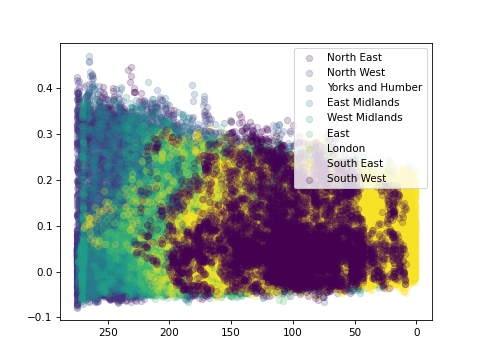

In [19]:
fig , ax = plt.subplots()

N = len(df['Region name'].unique())

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0, 1, N))) # Set discrete-from-continuous colour cycler in Viridis

In [20]:
for group, frame in df.groupby('Region name'):
    
    ax.scatter(frame.lag_price_rank, frame.Y3_price_change, alpha=0.2, label=group)
    
ax.invert_xaxis()

plt.legend();

This is clearly too busy, it is almost 300 local regions and their house price change each month for over 20 years so that makes sens. We can make this a lot better, and observe the interesting ripple effect where prices increase in more expensive areas, followed by less expensive ones, by iteratively plotting the price change for each area every month.

<IPython.core.display.Javascript object>


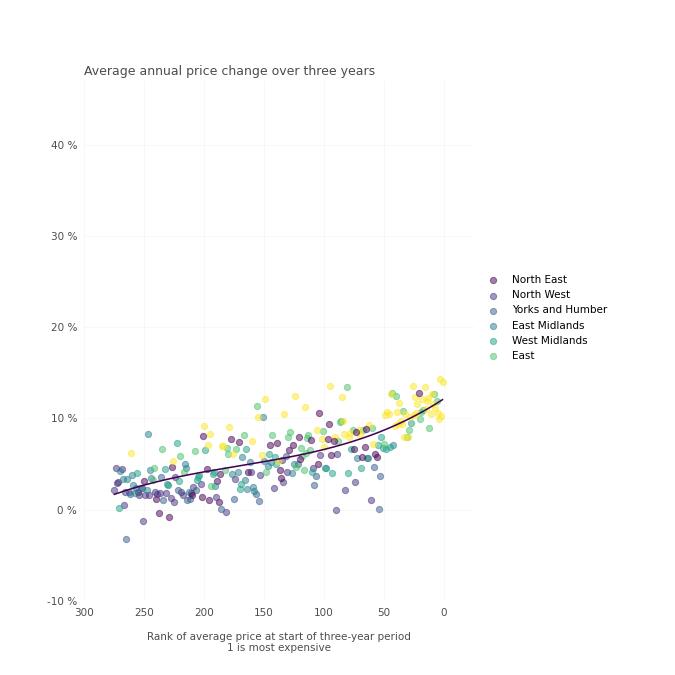

<ipython-input-21-2897ed4ba8c9>:16: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axes[1].annotate('Data from\nUK House Price Index', (1, 0), textcoords='axes fraction',


In [21]:
%matplotlib notebook

fig1, axes = plt.subplots(1,2,figsize=(9,9), gridspec_kw={'width_ratios': [7, 1]}) # Set up figure canvas
ax1 = axes[0]

for spine in axes[1].spines.values(): # using subplot for spacing - remove all the borders and ticks etc. 
    spine.set_visible(False)
    
    
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_facecolor('none')

axes[1].annotate('Data from\nUK House Price Index', (1, 0), textcoords='axes fraction',
                verticalalignment='bottom', horizontalalignment='right', alpha=0.7);



In [22]:
plt.sca(ax1)

DOWNLOAD = False

fig_counter = 1

groupby = df.groupby('Date')

for date in df.Date.unique():
    
    plt.gca().cla()
    
    ax1.set_xlim(300, -25)
    ax1.set_ylim(-10, 47)
    
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        
    frame = groupby.get_group(date).sort_values('lag_price_rank')
    
    for group, frame1 in frame.groupby('Region name'):
        
        X, Y = frame1['lag_price_rank'], frame1['Y3_price_change']*100

        scat = ax1.scatter(X, Y, label=group, alpha=0.5)
        
    X, Y = frame['lag_price_rank'], frame['Y3_price_change']*100
    trendpoly = np.poly1d(np.polyfit(X, Y, 3))
    trend = ax1.plot(X, trendpoly(X))[0]
    ax1.legend(bbox_to_anchor=(1,0.5), loc="center left", frameon=False)
    plt.subplots_adjust(right=.85)
    
    alph = 0.7
    
    ax1.grid(axis='y', alpha=0.1)
    ax1.grid(axis='x', alpha=0.1)
    plt.suptitle(f'House price growth in England by initial price rank: {str(date)[:10]}',
             x=0.124, y=.94, horizontalalignment='left', size='x-large', alpha = alph)
    plt.title('Average annual price change over three years',
             loc='left', alpha = alph)
    plt.xlabel('Rank of average price at start of three-year period\n1 is most expensive', labelpad=13, alpha=alph)
    

    plt.tick_params(axis='x',bottom=False, left=False)
    plt.tick_params(axis='y',bottom=False, left=False)
    
    plt.setp(ax1.get_xticklabels(), alpha=alph) # Change tick label alpha
    plt.setp(ax1.get_yticklabels(), alpha=alph)
    
    ax1.yaxis.set_major_formatter(FormatStrFormatter(r'%d %%'))
    
    if date == df.Date.unique()[0]:
        plt.show()

    else:
        fig1.canvas.draw()
    
    
    if DOWNLOAD: # These frames can be made into a gif using ffmpeg - serious TODO here is to use animate package instead
        plt.savefig('frames/UK_price_ripple_'+str(fig_counter))
        fig_counter+=1
        
    
    plt.pause(0.005)

KeyboardInterrupt: 

In [ ]:
! ffmpeg -i frames/UK_price_ripple_%d.png -vf palettegen palette.png  # needs palette otherwise colours are messed up

In [27]:
! ffmpeg -framerate 10 -i frames/UK_price_ripple_%d.png -i palette.png -lavfi paletteuse UK_house_ripple_10fps.gif 
    # create gif from frames

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.5 (clang-1205.0.22.9)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil      5

### Final GIF

<img src="UK_house_ripple_10fps.gif" width="750" align="center">


### TO DO:
- Use FuncAnimate package instead of loop as used here - currently generating animated gif using ffmpeg
- figure out how to fix label colour bug - South West region is 'ordered' appropriately in legend but is not coloured in it's appropriate order, it should be yellow instead of dark purple
- Make the same animation using another library, such as plotly or seaborn. Plotly might make this far easier, and a comparison would be interesting